In [2]:
import networkx as nx

In [3]:
G = nx.read_graphml('../graphs/coauthorship_graph.xml')

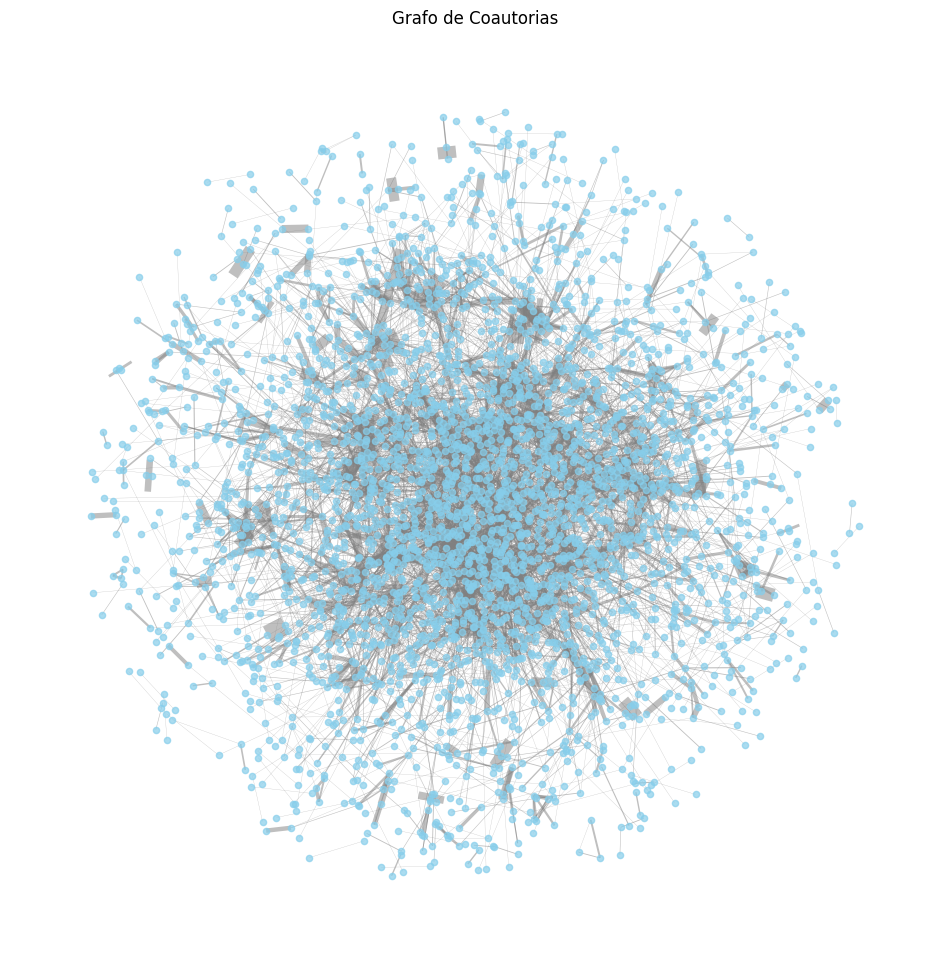

In [5]:
import matplotlib.pyplot as plt
import networkx as nx

min_weight_edge = -1


# Configurar o layout do grafo
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.1, seed=42)  # 'k' controla a distância entre os nós

# Configurar as arestas com pesos (exibir apenas arestas com peso > 1 para melhor visualização)
edges = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] > min_weight_edge]
weights = [G[u][v]['weight'] for u, v in edges]

# Desenhar nós
nx.draw_networkx_nodes(G, pos, node_size=20, node_color='skyblue', alpha=0.7)

# Desenhar arestas ponderadas
nx.draw_networkx_edges(G, pos, edgelist=edges, width=[w * 0.2 for w in weights], edge_color='gray', alpha=0.5)

# Adicionar rótulos aos nós (apenas alguns, para evitar poluição visual)
sampled_nodes = dict(list(pos.items())[:50])  # Limita a visualização de rótulos a 50 nós
# nx.draw_networkx_labels(G, sampled_nodes, font_size=6, font_color='black', font_family='sans-serif')

# Ocultar eixos e mostrar o grafo
plt.axis('off')
plt.title("Grafo de Coautorias")
plt.show()